In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
import spacy; from spacy.lang.en import English; nlp = English()
from metrics import *
from utils import *

In [3]:
inputs = pd.read_pickle("./fullfeatures.pickle")
outputs = pd.read_csv("./essay_scores.csv", sep=",")
# outputs.sample(frac=1)

In [4]:
inputs.head()

,essay_id,essay_set,tokenize,sequence,pad_seq,len,sent_count,avg_sent_len,punc_count,oov_count,noun_count,verb_count,adv_count,adj_count,det_count,max_depth,avg_depth
0,1,1,"[dear, local, newspaper, i, think, effects, co...","[302, 485, 427, 7, 67, 524, 42, 20, 18, 21, 19...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.628571,556.818182,1.171429,0.228571,2.742857,2.028571,0.742857,0.514286,0.914286,12,3.987212
1,2,1,"[dear, @caps, @caps, i, believe, that, using, ...","[302, 11, 11, 7, 176, 6, 312, 42, 60, 634, 105...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.208571,0.542857,779.210526,0.828571,0.428571,3.400000,2.857143,0.885714,0.600000,1.285714,13,4.482301
2,3,1,"[dear, @caps, @caps, @caps, more, and, more, p...","[302, 11, 11, 11, 76, 3, 76, 21, 122, 42, 35, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.808571,0.571429,495.250000,0.628571,0.200000,2.400000,1.685714,0.514286,0.542857,0.857143,10,3.531148
3,4,1,"[dear, local, newspaper, @caps, i, have, found...","[302, 485, 427, 11, 7, 20, 250, 6, 73, 1267, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.511429,1.257143,420.795455,1.257143,1.400000,4.600000,3.228571,1.085714,1.085714,1.514286,10,3.268761
4,5,1,"[dear, @location, i, know, having, computers, ...","[302, 127, 7, 90, 235, 42, 95, 4, 346, 288, 18...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.351429,0.857143,551.833333,1.285714,0.371429,3.400000,3.257143,1.314286,0.828571,1.742857,13,3.559846


In [5]:
outputs.describe()

,Unnamed: 0,essay_id,score,Prompt Adherence,Narrativity,Language,Word Choice,Sentence Fluency,Organization,Conventions,Content
count,12701.000000,12701.000000,12701.000000,7065.000000,7065.000000,8398.000000,4303.000000,4303.000000,5636.000000,5636.000000,12701.000000
mean,6350.750492,10146.244233,0.597175,0.451699,0.470193,0.509040,0.494585,0.515547,0.532032,0.546227,0.485648
std,3666.931576,6266.039109,0.233834,0.286019,0.277591,0.270596,0.207677,0.197891,0.231308,0.231587,0.269731
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3176.000000,4372.000000,0.500000,0.250000,0.333333,0.333333,0.400000,0.400000,0.400000,0.400000,0.333333
50%,6351.000000,9941.000000,0.625000,0.500000,0.500000,0.500000,0.600000,0.600000,0.600000,0.600000,0.500000
75%,9526.000000,15513.000000,0.750000,0.666667,0.666667,0.666667,0.600000,0.600000,0.666667,0.666667,0.666667
max,12701.000000,21633.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
w2vModel = Word2Vec.load('Essayw2v.model')
vocab = set(w2vModel.wv.vocab)
dic = w2vModel.wv
w2v = dict(zip(w2vModel.wv.index2word, w2vModel.wv.syn0))

/home/pranav_pro/SchoolSystem/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  after removing the cwd from sys.path.


In [7]:
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
word_index = tokenizer.word_index
MaxSequence = 1200

In [8]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    if word in vocab:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = dic[word]

In [9]:
embedding_layer = layers.Embedding(len(word_index) + 1,
                            300,
                            weights=[embedding_matrix],
                            input_length=MaxSequence,
                            trainable=False)

In [15]:
def build_model():
    main_input = layers.Input(shape=(MaxSequence,), dtype='int32', name='main_input')
    emb = embedding_layer(main_input)
    conv_out = layers.Conv1D(32, 5, activation='relu')(emb)
    pooled = layers.MaxPooling1D(35)(conv_out)
    flat = layers.Flatten()(pooled)
    auxiliary_output = layers.Dense(1,activation="sigmoid", name="aux_output")(flat)
    auxiliary_input = layers.Input(shape=(11,), name='aux_input')
    x = layers.concatenate([flat, auxiliary_input])
#     dropped = layers.Dropout(0.4)(x) 
    d1 = layers.Dense(16, activation='relu')(x)
    auxiliary_output_2 = layers.Dense(1,activation="sigmoid", name="aux_output_2")(d1)
    d1 = layers.Dropout(0.4)(d1)
    d1 = layers.Dense(16, activation='relu')(d1)
    main_output = layers.Dense(1,activation="sigmoid", name='main_output')(d1)
    model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output, auxiliary_output_2])
    model.compile(loss='mean_squared_error',
                optimizer='adam')
    return model
model = build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 1200)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1200, 300)    12767400    main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1196, 32)     48032       embedding[1][0]                  
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 34, 32)       0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 

In [16]:
# def build_model():
#     model = Sequential()
#     model.add(layers.InputLayer((MaxSequence,), dtype='int32'))
#     model.add(embedding_layer)
#     model.add(layers.Conv1D(64, 5, activation='relu'))
#     model.add(layers.MaxPooling1D(35))
#     model.add(layers.Flatten())
#     model.add(layers.Dropout(0.4))
#     model.add(layers.Dense(64, activation='relu'))
#     model.add(layers.Dense(1,activation="linear"))

#     optimizer = tf.keras.optimizers.RMSprop(0.001)

#     model.compile(loss='mean_squared_error',
#                 optimizer='adam',
#                 metrics=['mean_squared_error'])
#     return model

In [17]:
tf.test.is_gpu_available()

False

In [18]:
from tensorflow.keras.callbacks import Callback

class IntervalEvaluation(Callback):
    def __init__(self, validation_data=(), interval=10):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = kappa(self.y_val, y_pred*10,weights='quadratic')
            print("interval evaluation - epoch: {:d} - score: {:.6f}".format(epoch, score))

In [19]:
# temp = pd.merge(inputs, outputs, on=["essay_id", "essay_id"])
# train=temp.sample(frac=1,random_state=200)
# test=temp.drop(train.index)
# main_input = np.array(train['pad_seq'].values.tolist())
# aux_input = np.array(train[['sent_count','avg_sent_len','punc_count','oov_count','noun_count','verb_count','adv_count','adj_count','det_count','max_depth','avg_depth']].values.tolist())
# main_output = np.array(train['score'].values.tolist())
# model = build_model()
# model.summary()
# history = model.fit([main_input, aux_input], [main_output, main_output], validation_split = 0.1, epochs=10, verbose=1)

In [22]:
# required = ['score','Narrativity', 'Language', 'Word Choice', 'Sentence Fluency', 'Organization', 'Conventions', 'Content']  
required = ['score']
histories = {}
for desired in required:
    print("Preparing model for "+ desired)
    temp = outputs[outputs[desired]==outputs[desired]]
    temp = pd.merge(inputs, temp, on=["essay_id", "essay_id"])
    train=temp.sample(frac=1,random_state=200)
    test=temp.drop(train.index)
    main_input = np.array(train['pad_seq'].values.tolist())
    aux_input = np.array(train[['sent_count','avg_sent_len','punc_count','oov_count','noun_count','verb_count','adv_count','adj_count','det_count','max_depth','avg_depth']].values.tolist())
    main_output = np.array(train['score'].values.tolist())
    model = build_model()
#     model.summary()
    histories[desired] = model.fit([main_input, aux_input], [main_output, main_output, main_output], validation_split = 0.1, epochs=5, verbose=1)
#     histories[desired] = model.fit([main_input, aux_input], [main_output, main_output], epochs=1, verbose=1)
    histories[desired] = histories[desired].history
    print("Prepared model for "+ desired)
    model.save("./finalModels_v2/EssayModel_"+desired+".h5")
with open('modelHistories.pkl', 'wb') as f:
        pickle.dump(histories, f, pickle.HIGHEST_PROTOCOL)
histories

Preparing model for score
Train on 11430 samples, validate on 1271 samples
Epoch 1/5
11430/11430 [==============================] - 107s 9ms/sample - loss: 0.2293 - main_output_loss: 0.0905 - aux_output_loss: 0.0457 - aux_output_2_loss: 0.0928 - val_loss: 0.1188 - val_main_output_loss: 0.0406 - val_aux_output_loss: 0.0314 - val_aux_output_2_loss: 0.0468
Epoch 2/5
11430/11430 [==============================] - 106s 9ms/sample - loss: 0.1007 - main_output_loss: 0.0350 - aux_output_loss: 0.0280 - aux_output_2_loss: 0.0374 - val_loss: 0.1032 - val_main_output_loss: 0.0321 - val_aux_output_loss: 0.0342 - val_aux_output_2_loss: 0.0365
Epoch 3/5
11430/11430 [==============================] - 105s 9ms/sample - loss: 0.0807 - main_output_loss: 0.0300 - aux_output_loss: 0.0220 - aux_output_2_loss: 0.0288 - val_loss: 0.0880 - val_main_output_loss: 0.0299 - val_aux_output_loss: 0.0276 - val_aux_output_2_loss: 0.0305
Epoch 4/5
11430/11430 [==============================] - 106s 9ms/sample - loss: 0

{'score': {'loss': [0.22925164625896036,
   0.10067841380912801,
   0.08066778922696334,
   0.07044667161068996,
   0.06290751472441439],
  'main_output_loss': [0.09048576,
   0.035044227,
   0.029998913,
   0.027248979,
   0.025255853],
  'aux_output_loss': [0.045688655,
   0.02803615,
   0.021970458,
   0.019465655,
   0.017693302],
  'aux_output_2_loss': [0.09281638,
   0.037441567,
   0.028770417,
   0.023672588,
   0.020357758],
  'val_loss': [0.11878549417203847,
   0.10317743089516082,
   0.08795578498759671,
   0.09131468445015742,
   0.08469061799095336],
  'val_main_output_loss': [0.040633023,
   0.032130364,
   0.029934008,
   0.030945322,
   0.030917853],
  'val_aux_output_loss': [0.031395663,
   0.034229357,
   0.027586337,
   0.031947754,
   0.026977077],
  'val_aux_output_2_loss': [0.046756998,
   0.03645419,
   0.030523088,
   0.028410971,
   0.02683113]}}

In [23]:
# temp = pd.merge(inputs, outputs, on=["essay_id", "essay_id"])

# trainX, trainY, testX, testY = buildData(np.array(temp['pad_seq'].values.tolist()),np.array(temp['score'].values.tolist()))
# model = build_model()
# model.summary()
# ival = IntervalEvaluation(validation_data=(testX, testY*10), interval=1)
# # history = model.fit(trainX, trainY, epochs=5,  callbacks=[ival], validation_split = 0.1, verbose=1)
# history = model.fit(trainX, trainY, epochs=10,  callbacks=[ival], verbose=1)

In [24]:
histories['score']

{'loss': [0.22925164625896036,
  0.10067841380912801,
  0.08066778922696334,
  0.07044667161068996,
  0.06290751472441439],
 'main_output_loss': [0.09048576,
  0.035044227,
  0.029998913,
  0.027248979,
  0.025255853],
 'aux_output_loss': [0.045688655,
  0.02803615,
  0.021970458,
  0.019465655,
  0.017693302],
 'aux_output_2_loss': [0.09281638,
  0.037441567,
  0.028770417,
  0.023672588,
  0.020357758],
 'val_loss': [0.11878549417203847,
  0.10317743089516082,
  0.08795578498759671,
  0.09131468445015742,
  0.08469061799095336],
 'val_main_output_loss': [0.040633023,
  0.032130364,
  0.029934008,
  0.030945322,
  0.030917853],
 'val_aux_output_loss': [0.031395663,
  0.034229357,
  0.027586337,
  0.031947754,
  0.026977077],
 'val_aux_output_2_loss': [0.046756998,
  0.03645419,
  0.030523088,
  0.028410971,
  0.02683113]}

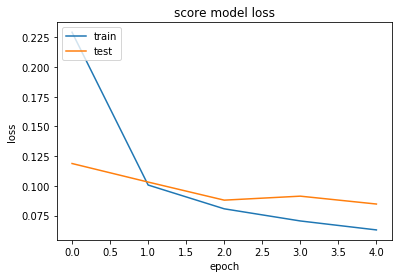

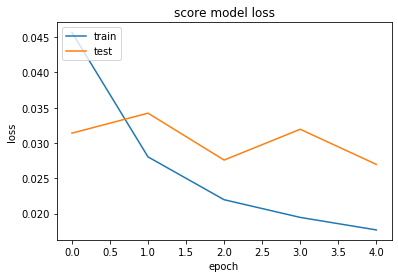

In [26]:
for scores in required:
    plt.plot(histories[scores]['loss'])
    plt.plot(histories[scores]['val_loss'])
    plt.title(scores+ ' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.plot(histories[scores]['aux_output_loss'])
    plt.plot(histories[scores]['val_aux_output_loss'])
    plt.title(scores+ ' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()